In [1]:
import pandas as pd
import matplotlib.pyplot as plt

Let's read the json file and gather some basic info about the dataframe we create.

In [2]:
df = pd.read_json('logins.json')
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
df.dtypes

login_time    datetime64[ns]
dtype: object

In [4]:
df.describe(datetime_is_numeric=True)

,login_time
count,93142
mean,1970-02-26 19:09:39.779648278
min,1970-01-01 20:12:16
25%,1970-02-04 10:37:19.750000
50%,1970-03-01 06:33:05.500000
75%,1970-03-22 04:01:10.750000
max,1970-04-13 18:57:38


This dataframe contains records of 93142 logins starting at about 8PM on Jan 1, 1970 and ending at about 7 PM on April 13, 1970. Note that the last half of April is missing, which would affect monthly sums of logins. Now let's resample the dataframe to count the logins during 15 minute intervals.

In [5]:
df = df.resample('15min', on='login_time').count()
df = df.rename(columns={'login_time':'login_count'})
df.sort_index(inplace=True)
df = df.reset_index()
df.head()

,login_time,login_count
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1


In [6]:
df.tail()

,login_time,login_count
9783,1970-04-13 17:45:00,5
9784,1970-04-13 18:00:00,5
9785,1970-04-13 18:15:00,2
9786,1970-04-13 18:30:00,7
9787,1970-04-13 18:45:00,6


In [7]:
df.describe()

,login_count
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


We can see that during the average 15 minute interval over the entire span, 9.5 logins were made. However, some 15 minute intervals had no logins, while 1 had 73 logins and the standard deviation is almost as large as the mean. Let's plot this data.

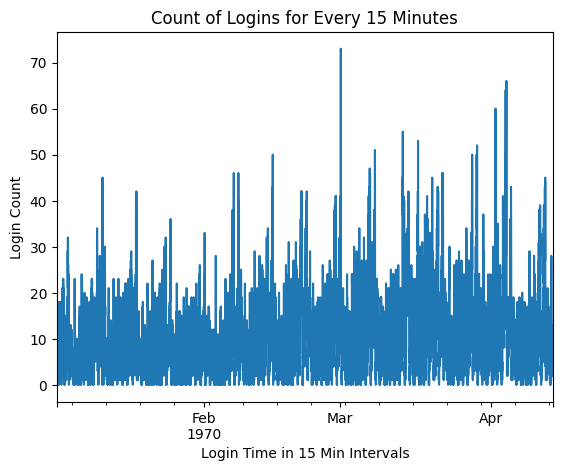

In [8]:
fig, ax = plt.subplots()
df.plot(x='login_time', y='login_count', ax=ax, legend=None)
ax.set_title('Count of Logins for Every 15 Minutes')
ax.set_ylabel('Login Count')
ax.set_xlabel('Login Time in 15 Min Intervals')
plt.show()

Plotting this we do not see an obvious trend, but there does appear to be some seasonality. At this resolution weekly seasonality is possible, but I cannot make a determination on daily seasonality. Now let's seperate our login time column into it's component parts so that we can analyze them. Every data point is from 1970 so I will ignore that, but I will make month, day, and time columns.

In [9]:
df['15_min_chunk'] = df['login_time'].dt.time
df['weekday'] = df['login_time'].dt.day_of_week
df['month'] = df['login_time'].dt.month
df.head()

,login_time,login_count,15_min_chunk,weekday,month
0,1970-01-01 20:00:00,2,20:00:00,3,1
1,1970-01-01 20:15:00,6,20:15:00,3,1
2,1970-01-01 20:30:00,9,20:30:00,3,1
3,1970-01-01 20:45:00,7,20:45:00,3,1
4,1970-01-01 21:00:00,1,21:00:00,3,1


Now let's take a look at the average day.

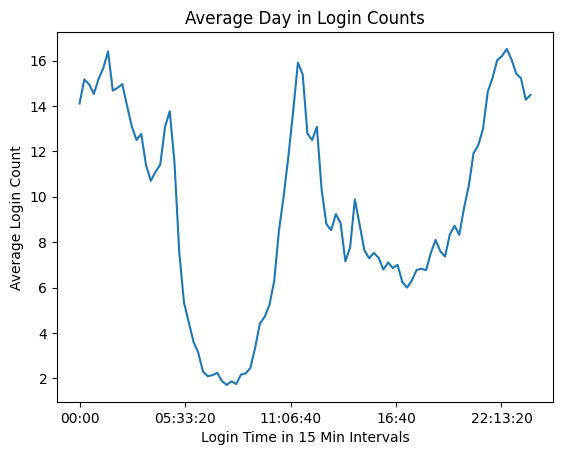

In [10]:
average_day = df.groupby(['15_min_chunk']).mean()
average_day = average_day.reset_index()
average_day = average_day.drop(columns=['weekday', 'month'])

fig, ax = plt.subplots()
average_day.plot(x='15_min_chunk', y='login_count', ax=ax, legend=None)
ax.set_title('Average Day in Login Counts')
ax.set_ylabel('Average Login Count')
ax.set_xlabel('Login Time in 15 Min Intervals')
plt.show()

When every day in our data set is averaged across it's 15 minute time intervals we create a plot of the average day. It appears that there are many logins in the early morning, followed by a trough and then a peak around noon, another trough, and then a final peak approaching midnight. Let's see if there is a weekly trend.

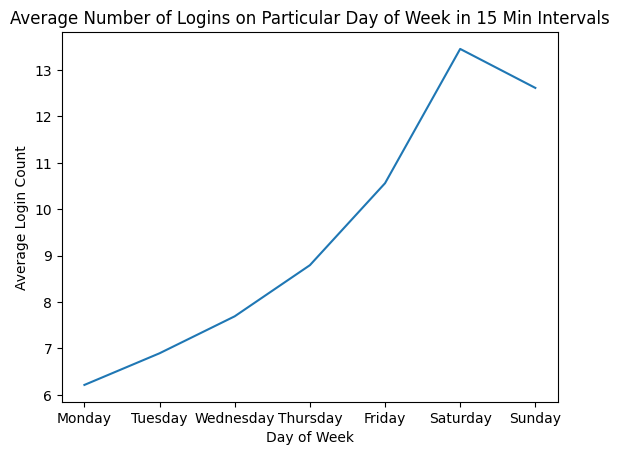

In [11]:
average_week = df.groupby(['weekday']).mean()
average_week = average_week.reset_index()
average_week = average_week.drop(columns=['month'])
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig, ax = plt.subplots()
average_week.plot(x='weekday', y='login_count', ax=ax, legend=None)
ax.set_title('Average Number of Logins on Particular Day of Week in 15 Min Intervals')
ax.set_ylabel('Average Login Count')
ax.set_xlabel('Day of Week')
ax.set_xticks(range(0,7))
ax.set_xticklabels(days)
plt.show()

This plot shows the average login count of every 15 minute interval in every day. It appears Monday's have the lowest number of logins on average, and that logins continuously rise during the week until Saturday, then they drop a bit on Sunday. Let's take a look at the months now.

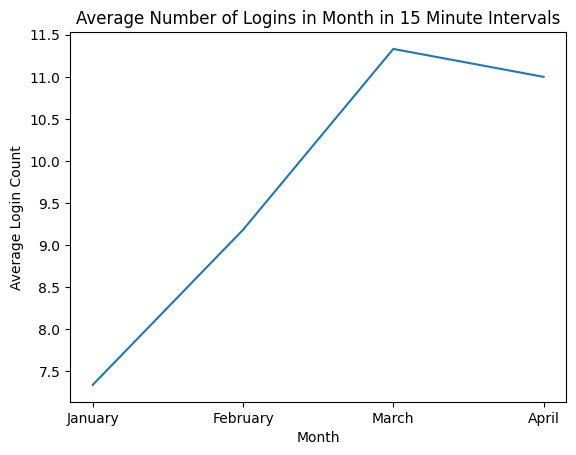

In [12]:
average_month = df.groupby(['month']).mean()
average_month = average_month.reset_index()
average_month = average_month.drop(columns=['weekday'])
months = ['January', 'February', 'March', 'April']

fig, ax = plt.subplots()
average_month.plot(x='month', y='login_count', ax=ax, legend=None)
ax.set_title('Average Number of Logins in Month in 15 Minute Intervals')
ax.set_ylabel('Average Login Count')
ax.set_xlabel('Month')
ax.set_xticks(range(1,5))
ax.set_xticklabels(months)
plt.show()

When averaging the logins during every 15 minute interval in a given month, it appears logins rise over the course of the year until April, when there is a slight decline. Earlier, when I made the average day, I noted peaks at midnight and noon, but it is possible that different days of the week have different character. I will now graph the average Monday, Tuesday, etc.

In [13]:
def average_day_of_week_plot(day_of_week):
    average_day_of_week = df.groupby(['weekday', '15_min_chunk']).mean().loc[day_of_week]
    average_day_of_week = average_day_of_week.reset_index()
    average_day_of_week = average_day_of_week.drop(columns=['month'])

    fig, ax = plt.subplots()
    average_day_of_week.plot(x='15_min_chunk', y='login_count', ax=ax, legend=None)
    ax.set_title('Average ' + days[day_of_week])
    ax.set_ylabel('Average Login Count')
    ax.set_xlabel('Login Time in 15 Minute Intervals')
    plt.show()

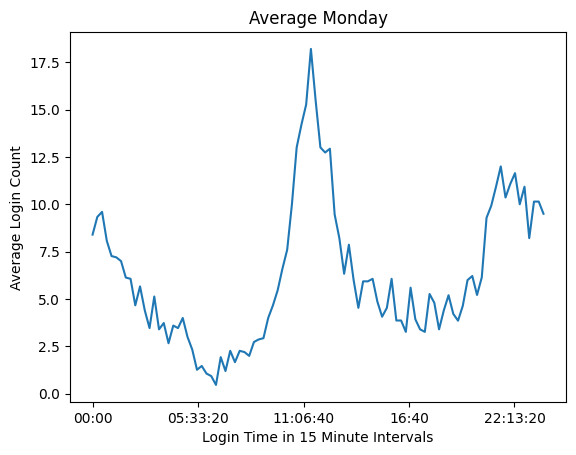

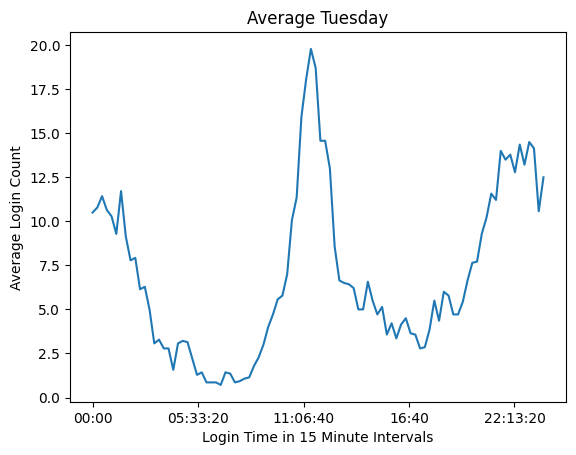

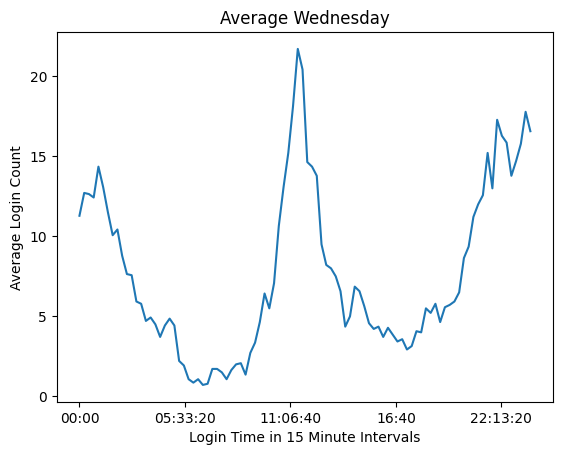

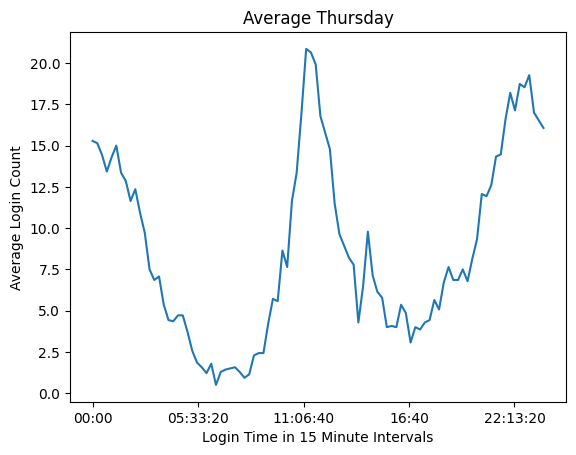

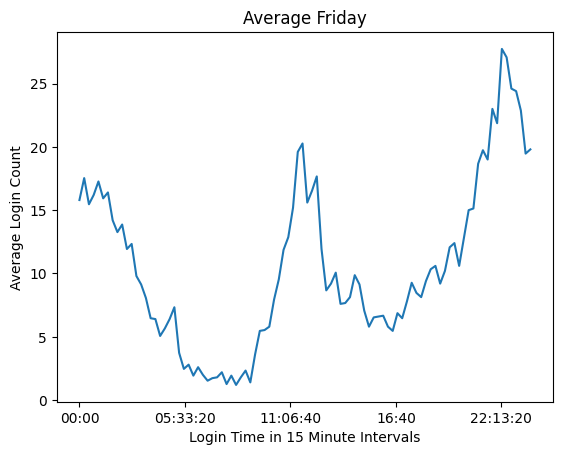

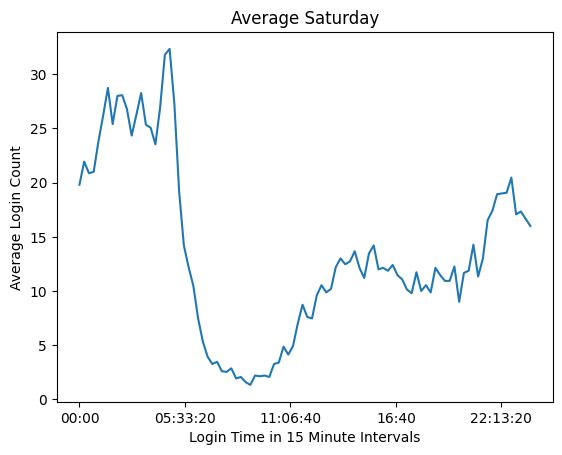

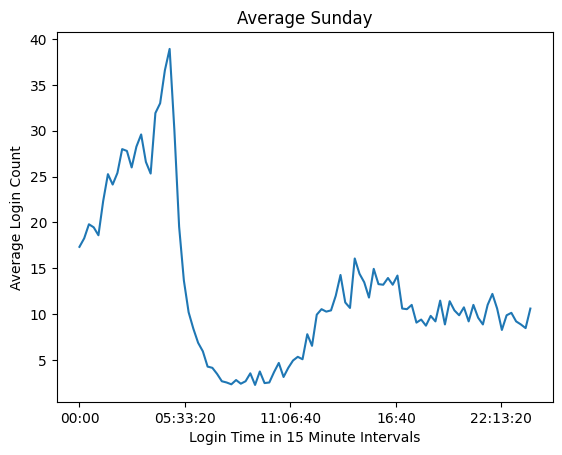

In [14]:
for i in range(7):
    average_day_of_week_plot(i)

Every Monday to Thursday has a minor peak at midnight and a major peak at noon. Friday evenings peak is much bigger than it's morning peak. Saturday and Sunday have very large peaks in the early morning, no Noon peak, followed by a rise on Saturday, but not on Sunday.